<a href="https://colab.research.google.com/github/Bareera2505/Deep-Learning-Labs/blob/main/Lab3_BM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **LAB3: Pytorch Operators and Optimizers**
### **Bareera Mirza**

# **Assignment: Fashion MNIST Classification**


In Lab3, we will use the Fashion MNIST dataset (see video recording for explanation of Fashion MNIST dataset). Similar to previous Lab2, you should design a fully-connected network as well as the pytorch based training/validation/testing process on the classification task. But differently, we will dive into the optimizers, operations or modules that we have learned in the lectures, and to see how they can benefit the capacity of your model.
Try different optimizers including RMSProp, Adam and SGD(You can find the corresponding functions in the torch.optim library). Log your training loss and test accuracy. Comparing these optimizers, how do they work? Which one is the best for this task and try to explain it.
Analyze the overfitting/underfitting situation of your model.

Try to use regularization like L2/L1, Dropout layers, etc. to improve your performance. How does your regularization work? And how do you balance your regularization and the loss optimization?


Try different initialization ways like random normal, Xavier and He (Kaiming) etc. How can these initialization affect your training process and performance?


Try normalization like batch normalization or layer normalization, whether these normalization methods can help your training or improve your performance?


To further improve the performance, you can also choose your own hyperparameters, including:
Number of layers
Number of neurons in each layer
Learning rate
Number of training epochs

For the comparing of different optimizers, regularization, initialization, normalization and hyper-parameters, you are recommended to form a table of the comparison results. Report your loss as ”loss curve” and accuracy for different settings and draw conclusions. You can split a small validation set from the training set to help you analyze the effectiveness of different modules better.

For the convenient implementation of different optimizers, regularization, initialization and normalization, you can always check the tutorial of pytorch library (https://pytorch.org/tutorials/) for some useful funuctions and examples.

In [1]:
# Import the necessary libraries
import numpy as np
import torch
import matplotlib.pyplot as plt
import torchvision 

In [2]:
train_batch_size = 100 # Define train batch size
test_batch_size  = 1000 # Define test batch size (can be larger than train batch size)


 #Use the following code to load and normalize the dataset
trainloader = torch.utils.data.DataLoader(
  torchvision.datasets.FashionMNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=train_batch_size, shuffle=True)

testloader = torch.utils.data.DataLoader(
  torchvision.datasets.FashionMNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=test_batch_size, shuffle=True)

In [3]:
# Examine a sample
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)


<class 'torch.Tensor'>
torch.Size([100, 1, 28, 28])
torch.Size([100])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


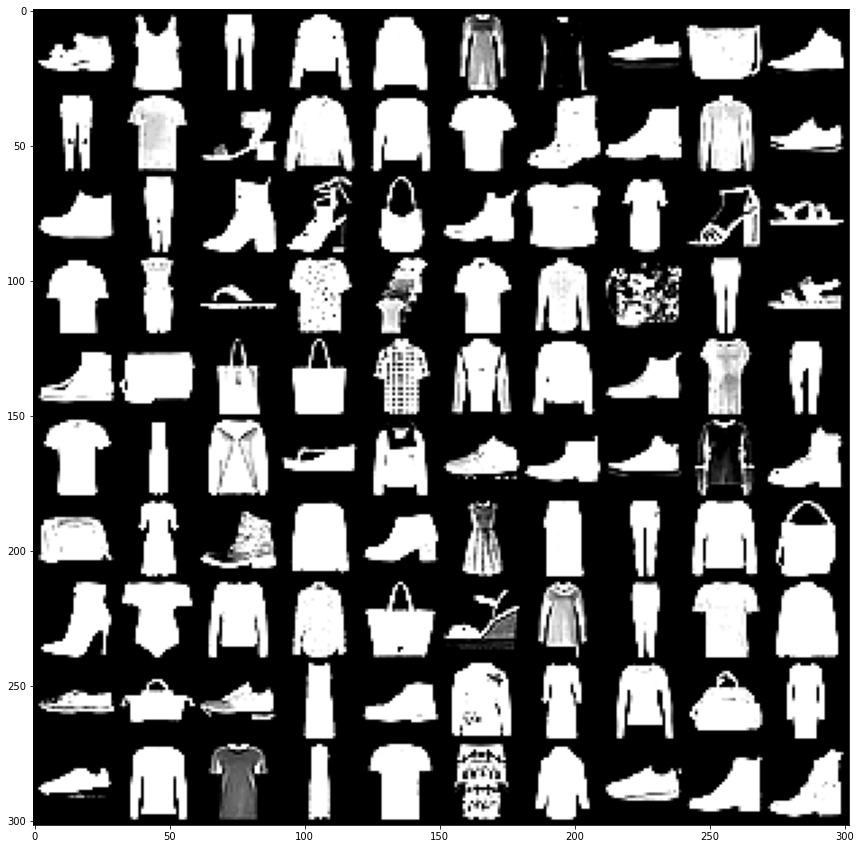

In [4]:
grid = torchvision.utils.make_grid(next(iter(trainloader))[0], nrow=10)

plt.figure(figsize=(15,15))
plt.imshow(grid.permute(1,2,0))

In [5]:
# Define the network architecture
from torch import nn, optim
import torch.nn.functional as F

model=nn.Sequential(nn.Linear(784, 256),
                      nn.ReLU(),
                      nn.Dropout(0.2),
                      nn.BatchNorm1d(256),
                      nn.Linear(256, 128),
                      nn.ReLU(),
                      nn.Dropout(0.2),
                      nn.BatchNorm1d(128),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.BatchNorm1d(64),
                      nn.Dropout(0.2),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim = 1)
                     )
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)


model.apply(init_weights)
print(model)

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): Linear(in_features=256, out_features=128, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.2, inplace=False)
  (7): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): Linear(in_features=128, out_features=64, bias=True)
  (9): ReLU()
  (10): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): Dropout(p=0.2, inplace=False)
  (12): Linear(in_features=64, out_features=10, bias=True)
  (13): LogSoftmax(dim=1)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


In [6]:
# Define the loss
criterion = nn.NLLLoss()


# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr = 0.0001)


# Define the epochs
epochs = 27

train_losses, test_losses = [], []

for e in range(epochs):
  running_loss = 0
  for images, labels in trainloader:
    # Flatten Fashion-MNIST images into a 784 long vector
    images = images.view(images.shape[0], -1)
    
    # Training pass
    optimizer.zero_grad()
    
    output = model.forward(images)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()
    
    running_loss += loss.item()
  else:
    test_loss = 0
    accuracy = 0
    
    # Turn off gradients for validation, saves memory and computation
    with torch.no_grad():
      # Set the model to evaluation mode
      model.eval()
      
      # Validation pass
      for images, labels in testloader:
        images = images.view(images.shape[0], -1)
        log_ps = model(images)
        test_loss += criterion(log_ps, labels)
        
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim = 1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))
    
    model.train()
    train_losses.append(running_loss/len(trainloader))
    test_losses.append(test_loss/len(testloader))
    
    print("Epoch: {}/{}..".format(e+1, epochs),
          "Training loss: {:.3f}..".format(running_loss/len(trainloader)),
          "Test loss: {:.3f}..".format(test_loss/len(testloader)),
          "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 1/27.. Training loss: 0.974.. Test loss: 0.535.. Test Accuracy: 0.812
Epoch: 2/27.. Training loss: 0.591.. Test loss: 0.450.. Test Accuracy: 0.838
Epoch: 3/27.. Training loss: 0.508.. Test loss: 0.418.. Test Accuracy: 0.848
Epoch: 4/27.. Training loss: 0.467.. Test loss: 0.399.. Test Accuracy: 0.855
Epoch: 5/27.. Training loss: 0.436.. Test loss: 0.385.. Test Accuracy: 0.862
Epoch: 6/27.. Training loss: 0.412.. Test loss: 0.376.. Test Accuracy: 0.863
Epoch: 7/27.. Training loss: 0.396.. Test loss: 0.365.. Test Accuracy: 0.869
Epoch: 8/27.. Training loss: 0.383.. Test loss: 0.357.. Test Accuracy: 0.872
Epoch: 9/27.. Training loss: 0.364.. Test loss: 0.354.. Test Accuracy: 0.873
Epoch: 10/27.. Training loss: 0.357.. Test loss: 0.344.. Test Accuracy: 0.875
Epoch: 11/27.. Training loss: 0.347.. Test loss: 0.341.. Test Accuracy: 0.877
Epoch: 12/27.. Training loss: 0.337.. Test loss: 0.340.. Test Accuracy: 0.879
Epoch: 13/27.. Training loss: 0.327.. Test loss: 0.336.. Test Accuracy: 0

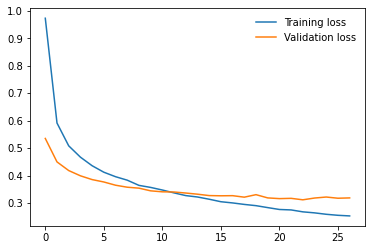

In [7]:
plt.plot(train_losses, label = "Training loss")
plt.plot(test_losses, label = "Validation loss")
plt.legend(frameon = False)

In [8]:
# Define the loss
criterion = nn.NLLLoss()



# Define the optimizer
optimizer=optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)


# Define the epochs
epochs = 29

train_losses, test_losses = [], []

for e in range(epochs):
  running_loss = 0
  for images, labels in trainloader:
    # Flatten Fashion-MNIST images into a 784 long vector
    images = images.view(images.shape[0], -1)
    
    # Training pass
    optimizer.zero_grad()
    
    output = model.forward(images)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()
    
    running_loss += loss.item()
  else:
    test_loss = 0
    accuracy = 0
    
    # Turn off gradients for validation, saves memory and computation
    with torch.no_grad():
      # Set the model to evaluation mode
      model.eval()
      
      # Validation pass
      for images, labels in testloader:
        images = images.view(images.shape[0], -1)
        log_ps = model(images)
        test_loss += criterion(log_ps, labels)
        
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim = 1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))
    
    model.train()
    train_losses.append(running_loss/len(trainloader))
    test_losses.append(test_loss/len(testloader))
    
    print("Epoch: {}/{}..".format(e+1, epochs),
          "Training loss: {:.3f}..".format(running_loss/len(trainloader)),
          "Test loss: {:.3f}..".format(test_loss/len(testloader)),
          "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 1/29.. Training loss: 0.238.. Test loss: 0.310.. Test Accuracy: 0.890
Epoch: 2/29.. Training loss: 0.235.. Test loss: 0.311.. Test Accuracy: 0.890
Epoch: 3/29.. Training loss: 0.232.. Test loss: 0.311.. Test Accuracy: 0.890
Epoch: 4/29.. Training loss: 0.229.. Test loss: 0.307.. Test Accuracy: 0.891
Epoch: 5/29.. Training loss: 0.229.. Test loss: 0.310.. Test Accuracy: 0.890
Epoch: 6/29.. Training loss: 0.227.. Test loss: 0.308.. Test Accuracy: 0.890
Epoch: 7/29.. Training loss: 0.228.. Test loss: 0.308.. Test Accuracy: 0.891
Epoch: 8/29.. Training loss: 0.228.. Test loss: 0.310.. Test Accuracy: 0.891
Epoch: 9/29.. Training loss: 0.227.. Test loss: 0.307.. Test Accuracy: 0.891
Epoch: 10/29.. Training loss: 0.226.. Test loss: 0.308.. Test Accuracy: 0.893
Epoch: 11/29.. Training loss: 0.227.. Test loss: 0.308.. Test Accuracy: 0.891
Epoch: 12/29.. Training loss: 0.226.. Test loss: 0.307.. Test Accuracy: 0.890
Epoch: 13/29.. Training loss: 0.225.. Test loss: 0.308.. Test Accuracy: 0

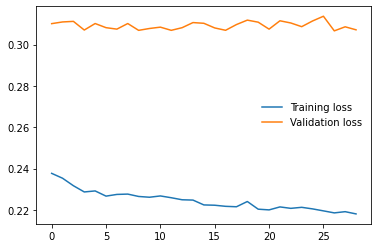

In [9]:
plt.plot(train_losses, label = "Training loss")
plt.plot(test_losses, label = "Validation loss")
plt.legend(frameon = False)

In [10]:

# Define the loss
criterion = nn.NLLLoss()


# Define the optimizer
optimizer=optim.RMSprop(model.parameters(), lr=0.002, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)


# Define the epochs
epochs = 25

train_losses, test_losses = [], []

for e in range(epochs):
  running_loss = 0
  for images, labels in trainloader:
    # Flatten Fashion-MNIST images into a 784 long vector
    images = images.view(images.shape[0], -1)
    
    # Training pass
    optimizer.zero_grad()
    
    output = model.forward(images)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()
    
    running_loss += loss.item()
  else:
    test_loss = 0
    accuracy = 0
    
    # Turn off gradients for validation, saves memory and computation
    with torch.no_grad():
      # Set the model to evaluation mode
      model.eval()
      
      # Validation pass
      for images, labels in testloader:
        images = images.view(images.shape[0], -1)
        log_ps = model(images)
        test_loss += criterion(log_ps, labels)
        
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim = 1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))
    
    model.train()
    train_losses.append(running_loss/len(trainloader))
    test_losses.append(test_loss/len(testloader))
    
    print("Epoch: {}/{}..".format(e+1, epochs),
          "Training loss: {:.3f}..".format(running_loss/len(trainloader)),
          "Test loss: {:.3f}..".format(test_loss/len(testloader)),
          "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 1/25.. Training loss: 0.488.. Test loss: 0.419.. Test Accuracy: 0.853
Epoch: 2/25.. Training loss: 0.401.. Test loss: 0.438.. Test Accuracy: 0.851
Epoch: 3/25.. Training loss: 0.377.. Test loss: 0.378.. Test Accuracy: 0.868
Epoch: 4/25.. Training loss: 0.360.. Test loss: 0.381.. Test Accuracy: 0.869
Epoch: 5/25.. Training loss: 0.343.. Test loss: 0.368.. Test Accuracy: 0.874
Epoch: 6/25.. Training loss: 0.332.. Test loss: 0.399.. Test Accuracy: 0.870
Epoch: 7/25.. Training loss: 0.325.. Test loss: 0.374.. Test Accuracy: 0.876
Epoch: 8/25.. Training loss: 0.315.. Test loss: 0.359.. Test Accuracy: 0.878
Epoch: 9/25.. Training loss: 0.308.. Test loss: 0.389.. Test Accuracy: 0.873
Epoch: 10/25.. Training loss: 0.304.. Test loss: 0.346.. Test Accuracy: 0.879
Epoch: 11/25.. Training loss: 0.296.. Test loss: 0.393.. Test Accuracy: 0.881
Epoch: 12/25.. Training loss: 0.290.. Test loss: 0.354.. Test Accuracy: 0.883
Epoch: 13/25.. Training loss: 0.286.. Test loss: 0.372.. Test Accuracy: 0

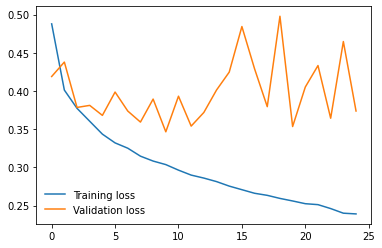

In [11]:
plt.plot(train_losses, label = "Training loss")
plt.plot(test_losses, label = "Validation loss")
plt.legend(frameon = False)

In [12]:
# Define the loss
criterion = nn.NLLLoss()

# Define the optimizer
optimizer=optim.RMSprop(model.parameters(), lr=0.0001, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)


# Define the epochs
epochs = 25

train_losses, test_losses = [], []

for e in range(epochs):
  running_loss = 0
  for images, labels in trainloader:
    # Flatten Fashion-MNIST images into a 784 long vector
    images = images.view(images.shape[0], -1)
    
    # Training pass
    optimizer.zero_grad()
    
    output = model.forward(images)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()
    
    running_loss += loss.item()
  else:
    test_loss = 0
    accuracy = 0
    
    # Turn off gradients for validation, saves memory and computation
    with torch.no_grad():
      # Set the model to evaluation mode
      model.eval()
      
      # Validation pass
      for images, labels in testloader:
        images = images.view(images.shape[0], -1)
        log_ps = model(images)
        test_loss += criterion(log_ps, labels)
        
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim = 1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))
    
    model.train()
    train_losses.append(running_loss/len(trainloader))
    test_losses.append(test_loss/len(testloader))
    
    print("Epoch: {}/{}..".format(e+1, epochs),
          "Training loss: {:.3f}..".format(running_loss/len(trainloader)),
          "Test loss: {:.3f}..".format(test_loss/len(testloader)),
          "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 1/25.. Training loss: 0.216.. Test loss: 0.378.. Test Accuracy: 0.897
Epoch: 2/25.. Training loss: 0.205.. Test loss: 0.365.. Test Accuracy: 0.898
Epoch: 3/25.. Training loss: 0.201.. Test loss: 0.389.. Test Accuracy: 0.898
Epoch: 4/25.. Training loss: 0.195.. Test loss: 0.339.. Test Accuracy: 0.899
Epoch: 5/25.. Training loss: 0.196.. Test loss: 0.376.. Test Accuracy: 0.901
Epoch: 6/25.. Training loss: 0.194.. Test loss: 0.357.. Test Accuracy: 0.900
Epoch: 7/25.. Training loss: 0.192.. Test loss: 0.431.. Test Accuracy: 0.900
Epoch: 8/25.. Training loss: 0.189.. Test loss: 0.488.. Test Accuracy: 0.898
Epoch: 9/25.. Training loss: 0.189.. Test loss: 0.453.. Test Accuracy: 0.898
Epoch: 10/25.. Training loss: 0.189.. Test loss: 0.524.. Test Accuracy: 0.901
Epoch: 11/25.. Training loss: 0.187.. Test loss: 0.364.. Test Accuracy: 0.901
Epoch: 12/25.. Training loss: 0.186.. Test loss: 0.427.. Test Accuracy: 0.900
Epoch: 13/25.. Training loss: 0.187.. Test loss: 0.336.. Test Accuracy: 0

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): Linear(in_features=256, out_features=128, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.2, inplace=False)
  (7): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): Linear(in_features=128, out_features=64, bias=True)
  (9): ReLU()
  (10): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): Dropout(p=0.2, inplace=False)
  (12): Linear(in_features=64, out_features=10, bias=True)
  (13): LogSoftmax(dim=1)
)


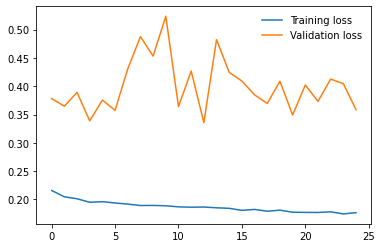

In [13]:
plt.plot(train_losses, label = "Training loss")
plt.plot(test_losses, label = "Validation loss")
plt.legend(frameon = False)
print(model)

Summary:
1. Optimizer: Adam 
              SGD
              RMSprop
Model Deatil:
Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)

  (1): ReLU()

  (2): Dropout(p=0.2, inplace=False)

  (3): Linear(in_features=256, out_features=128, bias=True)

  (4): ReLU()

  (5): Dropout(p=0.2, inplace=False)

  (6): Linear(in_features=128, out_features=64, bias=True)

  (7): ReLU()

  (8): Dropout(p=0.2, inplace=False)

  (9): Linear(in_features=64, out_features=10, bias=True)

  (10): LogSoftmax(dim=1)

  (11): Initialization Function=Xavier


Optimizer   	Learning Rate	    Accuracy	   Underfitting or Overfitting

Adam epochs=27	   0.0001	       89.2%	      Slightly Overfitting

Adam epochs=27	    0.002	       88.4%	        Overfitting

SGD epochs=29	      0.0001	     84.2%	       Underfitting

SGD epochs=29	       0.002	     88.9%	       Underfitting (slightly)

RMSprop epochs=25	   0.0001	     90%	        Too much overfitting

RMSprop epochs=25	    0.002	      88.7%	       Overfitting



2.We can try early stopping because if we stop at 10 then we can get better valudation and training loss. Another way is to try dropout (randomly drop units) which I tried but seems like need more fine tuning of parameters.


3.By intorducing Xavier intialization, the validation loss was smoothened little bit and it increase 0.1% to 2% of accuracy 


4.I tried batch normalization and it increased accuracy. It increased test loss moderately and decreased training loss slightly.


5.I changed learning rates and changed epochs (tried lr=0.002, 0.0001 and epochs 25-30 ).The accuracy of test by fine tuning hypermaters, I achieved accuracies summed up above.


**In conclusion: Out of all of them, Adam with lr=0.0001 works the best so  I would prefer to use it for future**
